In [120]:
#%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
     ---------------------------------------- 4.9/4.9 MB 8.5 MB/s eta 0:00:00
     ---------------------------------------- 2.5/2.5 MB 9.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [116]:
from vizdoom import *
import gym
from gym import Env
from gym.spaces import Box, Discrete
import cv2
import random
import time
import numpy as np
from matplotlib import pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common import env_checker
from stable_baselines3.common.callbacks import BaseCallback

In [2]:
game = DoomGame()
game.load_config('github/ViZDoom/scenarios/basic.cfg')
game.init()

In [3]:
for episode in range(5):
    game.new_episode()
    while not game.is_episode_finished():
        state = game.get_state()
        img = state.screen_buffer
        info = state.game_variables
        reward = game.make_action(random.choice(np.identity(3, dtype=np.uint8)))
        print(f'reward: {reward}')
        time.sleep(0.02)
    print(f"Result: {game.get_total_reward()}")
game.close()

reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -6.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -6.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -6.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -6.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0
reward: -1.0

In [111]:
class VizDoomGym(Env):
    def __init__(self, render=False):
        super().__init__()
        self.game = DoomGame()
        self.game.load_config('github/ViZDoom/scenarios/basic.cfg')
        
        if render == False:
            self.game.set_window_visible(False)
        else:
            self.game.set_window_visible(True)
        self.game.init()
        
        self.observation_space = Box(low=0, high=255, shape=(100, 160, 1), dtype=np.uint8)
        self.action_space = Discrete(3)
        
    def step(self, action):
        actions = np.identity(3, dtype=np.uint8)
        reward = self.game.make_action(actions[action])
        
        if self.game.get_state():
            state = self.game.get_state().screen_buffer
            state = self.grayscale(state)
            ammo = self.game.get_state().game_variables[0]
            info = ammo
        else:
            state = np.zeros(self.observation_space.shape)
            info = 0
        
        info = {'ammo': info}
        done = self.game.is_episode_finished()
        
        return state, reward, done, info
    
    def render():
        pass
    
    def reset(self):
        self.game.new_episode()
        state = self.game.get_state().screen_buffer
        return self.grayscale(state)
    
    def grayscale(self, observation):
        gray = cv2.cvtColor(np.moveaxis(observation, 0, -1), cv2.COLOR_BGR2GRAY)
        resize = cv2.resize(gray, (160,  100), interpolation=cv2.INTER_CUBIC)
        state = np.reshape(resize, (100, 160, 1))
        return state
    
    def close(self):
        self.game.close()

In [117]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
        
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

In [112]:
env = VizDoomGym(render=True)

In [113]:
env_checker.check_env(env)

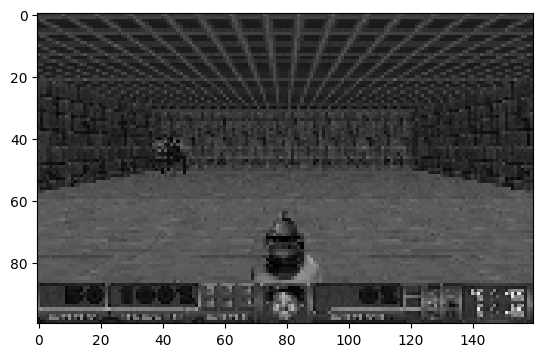

In [114]:
plt.imshow(cv2.cvtColor(env.reset(), cv2.COLOR_BGR2RGB))

In [115]:
env.close()

In [118]:
CHECKPOINT_DIR = './train/basic_train'
LOG_DIR = './logs/basic_log'

In [119]:
callback = TrainAndLoggingCallback(10000, CHECKPOINT_DIR)